Supplementary notebook to the manuscript "Unifying thermochemistry concepts in computational heterogeneous catalysis", by Dr. Bjarne Kreitz (Brown University), Dr. Gabriel Gusmao (Georgia Tech), Dr. David H. Bross (Argonne National Laboratory), Dingqi Nai (Georgia Tech), Jagriti Sahoo (Georgia Tech), Dr. C. Franklin Goldsmith (Brown University), Dr. Andrew J. Medford (Georgia Tech). 

Correspondence to Bjarne Kreitz (bjarne_kreitz@brown.edu) and Andrew J. Medford (ajm@gatech.edu)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

eV_to_kJmol=96.485

# Reference QM data to a set of anchor species using elemental chemical potentials

Enthalpies of formation of species (gas phase or adsorbed) can be calculated from the DFT energies by anchoring them to a set of reference species. A reference species is selected for every element to form an atomic basis set for the target species. These reference species are combined in a hypothetical reaction to form the target $P$, which is a generic $C_x H_y O_z$ gas-phase species or $C_x H_y O_z^*$ adsorbate. Common choices of reference species are $[CH_4, H_2, H_2O]$ and in the case of Pt(111), the empty slab has to be added as a reference species.

\begin{equation}
    \nu_{\text{C}} C + \nu_{\text{H}} H + \nu_{\text{O}} O + \nu_{\text{*}} * \rightarrow P
\end{equation}


The enthalpy of formation of the target can be determined from the DFT energies using the chemical potentials via

\begin{equation}
    \Delta_{\text{A}} H_{\text{P}} (0 K) =E_{\text{P}} - \sum_{k}^{N_{elements}} \nu_k  \mu_{k}^{\text{A}}
\end{equation}

In matrix notation this reads as

\begin{equation}
    \mathbf{\underline{H}}_{\text{A}}=\mathbf{\underline{E}}-\mathbf{\underline{\underline{N}}}\,\mathbf{\underline{\mu}}^{\text{A}}
\end{equation}

where $\mathbf{\underline{\underline{N}}}$ is the elemental composition matrix of the target species. 

Theoretically, it is possible to just use the DFT energies of the bare elements as the chemical potentials. 
However, it is impossible to calculate these accurately with DFT. Instead, we use calculate the elemental chemical potential from closed-shell reference species such as $[CH_4, H_2, H_2O]$ and in the case of Pt(111), the empty slab has to be added as a reference species. The chemical potentials can be derived via

\begin{align}
    &\mu_{\text{C}}=E_{CH_4}-2E_{H_2}\\
    &\mu_{\text{O}}=E_{H_2O}-E_{H_2}\\
    &\mu_{\text{H}}=0.5E_{H_2} \\
    &\mu_{\text{*}}=E_{Pt(111)}
\end{align}

It is also possible to use linear algebra to determine the elemental chemical potentials with the inverse of the elemental composition matrix of the reference species. 

\begin{equation}
 \mathbf{\underline{\mu}}=\mathbf{\underline{\underline{N}}}^{\text{A}^{-1}}\,\mathbf{\underline{E}}^\text{A}
\end{equation}

This is the list of species with their DFT energies from BEEF-vdW for which we want to compute the enthalpies of formation. We can create a vector $\mathbf{\underline{E}}$ that contains the energies from this dictionary.

In [3]:
#Target species for which we need to compute the EOFs
species_energies = {
    "C2H6": -615.3019939,
    "C2H6X" : -378231.5655,
    "XH": -377632.6636,
    "XCH2CH3": -378214.9168,
    "XO": -378193.2832,
    "XCH2XCH2": -378198.4442,
    "XCO": -378453.0261, 
    "CO2X": -379030.8164,
    "CO2": -1414.682864,
    "XOH": -378209.8045,
    "H2OX": -378227.2801,
    "CO": -835.5389907,
    "C2H4":-581.44565067567,   
    "CH4": -324.2935569,
    "H2": -32.69844421, 
    "H2O": -611.0186083,
    "X": -377616.072,
}

#vector of DFT energies of the target species from the dictionary
E=np.array(list(species_energies.values()))

We want to determine the enthalpies of formation with reference to $[CH_4, H_2, H_2O, Pt(111)]$. For which we determined the DFT energies. We construct the vector $\mathbf{\underline{E}}^{\text{A}}$ that contains the DFT energies of the reference species

In [4]:
ref_energies = {
    "CH4": -324.2935569,
    "H2": -32.69844421, 
    "H2O": -611.0186083,
    "X": -377616.072,
}

#vector of DFT energies of the reference species from the dictionary
E_A=np.array(list(ref_energies.values()))

We start now with constructing the elemental composition matrix of our target species $\mathbf{\underline{\underline{N}}}$, which is an $m \times n$ matrix with $m$ target species and $n$ elements. 

In [5]:
# Define the species and their elemental compositions in a dictionary
species_compositions = {
    "C2H6": {"C": 2, "H": 6, "O": 0, "X": 0},
    "C2H6X": {"C": 2, "H": 6, "O": 0, "X": 1},
    "XH": {"C": 0, "H": 1, "O": 0, "X": 1},
    "XCH2CH3": {"C": 2, "H": 5, "O": 0, "X": 1},
    "XO": {"C": 0, "H": 0, "O": 1, "X": 1},
    "XCH2XCH2": {"C": 2, "H": 4, "O": 0, "X": 1},
    "XCO": {"C": 1, "H": 0, "O": 1, "X": 1},
    "CO2X": {"C": 1, "H": 0, "O": 2, "X": 1},
    "CO2": {"C": 1, "H": 0, "O": 2, "X": 0},
    "XOH": {"C": 0, "H": 1, "O": 1, "X": 1},
    "H2OX": {"C": 0, "H": 2, "O": 1, "X": 1},
    "CO": {"C": 1, "H": 0, "O": 1, "X": 0},
    "C2H4": {"C": 2, "H": 4, "O": 0, "X": 0},
    "CH4": {"C": 1, "H": 4, "O": 0, "X": 0},
    "H2": {"C": 0, "H": 2, "O": 0, "X": 0},
    "H2O": {"C": 0, "H": 2, "O": 1, "X": 0},
    "X": {"C": 0, "H": 0, "O": 0, "X": 1},
}

species=list(species_compositions.keys())


# Create a matrix to hold the elemental compositions of the target species
num_species = len(species_compositions)
num_elements = 4  # C, H, O, X
N = np.zeros((num_species, num_elements))

# Fill in the elemental composition matrix of the target species
for s, composition in species_compositions.items():
    i = species.index(s)
    N[i, :] = [composition["C"], composition["H"], composition["O"], composition["X"]]
    
N

array([[2., 6., 0., 0.],
       [2., 6., 0., 1.],
       [0., 1., 0., 1.],
       [2., 5., 0., 1.],
       [0., 0., 1., 1.],
       [2., 4., 0., 1.],
       [1., 0., 1., 1.],
       [1., 0., 2., 1.],
       [1., 0., 2., 0.],
       [0., 1., 1., 1.],
       [0., 2., 1., 1.],
       [1., 0., 1., 0.],
       [2., 4., 0., 0.],
       [1., 4., 0., 0.],
       [0., 2., 0., 0.],
       [0., 2., 1., 0.],
       [0., 0., 0., 1.]])

We construct the elemental composition matrix of our reference species $\mathbf{\underline{\underline{N}}}^A$, which is an $m \times n$ matrix with $m$ reference species and $n$ elements. 

In [7]:
# Define the species and their elemental compositions in a dictionary
references_compositions = {
    "CH4": {"C": 1, "H": 4, "O": 0, "X": 0},
    "H2": {"C": 0, "H": 2, "O": 0, "X": 0},
    "H2O": {"C": 0, "H": 2, "O": 1, "X": 0},
    "X": {"C": 0, "H": 0, "O": 0, "X": 1},
}

references=list(references_compositions.keys())

# Create a matrix to hold the elemental compositions of the reference species
num_references = len(references_compositions)
N_A = np.zeros((num_references, num_elements))

# Fill in the elemental composition matrix of the reference species
for s, composition in references_compositions.items():
    i = references.index(s)
    N_A[i, :] = [composition["C"], composition["H"], composition["O"], composition["X"]]
    
N_A

array([[1., 4., 0., 0.],
       [0., 2., 0., 0.],
       [0., 2., 1., 0.],
       [0., 0., 0., 1.]])

We can now determine $\mathbf{\underline{\mu}}^{\text{A}}$ from the inverse of elemental composition matrix of the reference species $\mathbf{\underline{\underline{N}}}^{\text{A}}$ via

\begin{equation}
 \mathbf{\underline{\mu}^{\text{A}}}=\mathbf{\underline{\underline{N}}}^{\text{A}^{-1}}\,\mathbf{\underline{E}}^{\text{A}}
\end{equation}

In [9]:
#Calculate the matrix of stoichiometric coefficients to form the target from the reference species
mu=(np.linalg.inv(N_A)).dot(E_A)
elements=['C','H','O','X']

#Create a dictionary with the results
chemical_potentials = {elements[i]: mu[i] for i in range(len(elements))}
chemical_potentials

{'C': -258.89666848,
 'H': -16.349222105,
 'O': -578.3201640899999,
 'X': -377616.072}

The last step is to compute the enthalpies of formation using the matrix of stoichiometric coefficients of the formation reactions and the DFT energies of the target species and references

\begin{equation}
    \mathbf{\underline{H}}_{\text{A}}=\mathbf{\underline{E}}-\mathbf{\underline{\underline{N}}}\,\mathbf{\underline{\mu}}^{\text{A}}
\end{equation}


In [10]:
#Determine the enthalpy of formation of the target
Hf=(E-N.dot(mu))*eV_to_kJmol

#Create a dictionary with the results
enthalpies_of_formation = {species[i]: Hf[i] for i in range(len(species))}


enthalpies_of_formation

{'C2H6': 56.60540394966027,
 'C2H6X': 38.12793788724724,
 'XH': -23.38583120360563,
 'XCH2CH3': 67.02306258857047,
 'XO': 106.99840022391058,
 'XCH2XCH2': 78.92717878597584,
 'XCO': 25.349752010967933,
 'CO2X': 76.47368873743049,
 'CO2': 82.41098970007852,
 'XOH': 90.39546452235372,
 'H2OX': -18.283106671951536,
 'CO': 161.88657282694535,
 'C2H4': 168.32529034728336,
 'CH4': 0.0,
 'H2': 0.0,
 'H2O': 0.0,
 'X': 0.0}

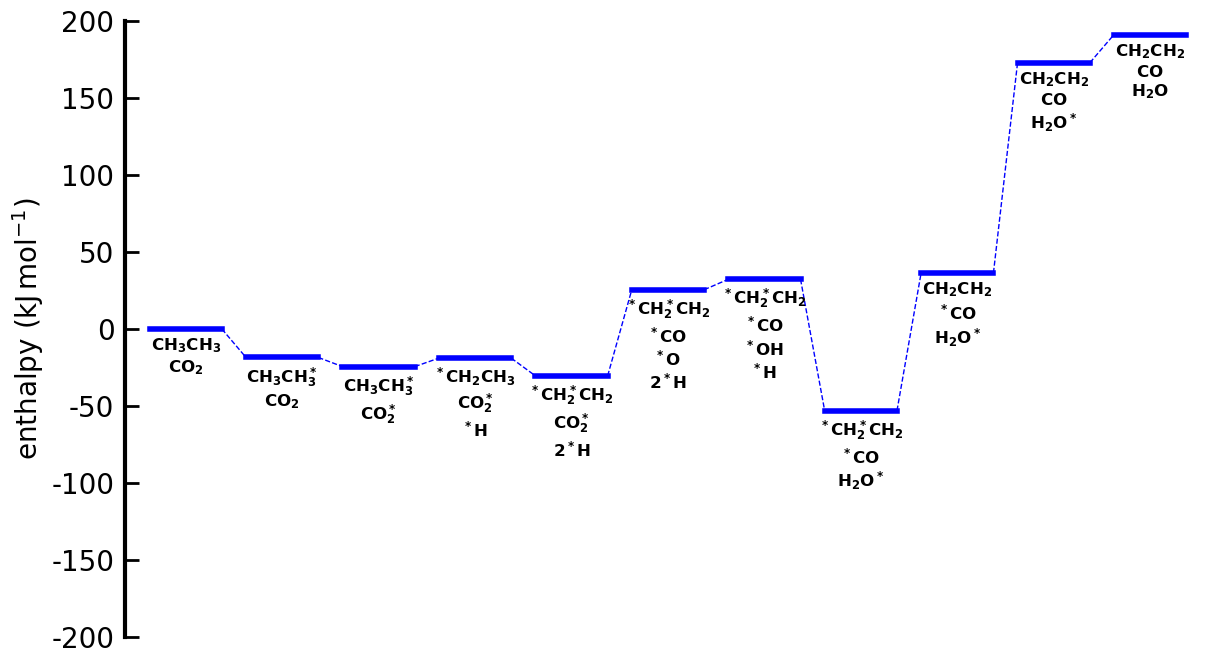

In [11]:
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['axes.linewidth'] = 3
plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)
plt.rc('axes', labelsize=20)
plt.rc('legend', fontsize=20)
plt.rcParams['lines.markersize'] = 10
plt.rcParams['lines.linewidth'] = 4
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.major.size'] = 10
plt.rcParams['xtick.major.width'] = 2
plt.rcParams['ytick.major.size'] = 10
plt.rcParams['ytick.major.width'] = 2
plt.rcParams['legend.edgecolor'] = 'k'
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams["legend.framealpha"] = 1
plt.rcParams['xtick.major.pad'] = 8
plt.rcParams['ytick.major.pad'] = 8
plt.rcParams['legend.handletextpad'] = 0.2
plt.rcParams['legend.columnspacing'] = 0.1
plt.rcParams['legend.labelspacing'] = 0.1
plt.rcParams['legend.title_fontsize'] = 14
plt.rcParams['axes.formatter.limits'] = (-3, 6)


gs = gridspec.GridSpec(nrows=1, ncols=1)
gs.update(wspace=0.5, hspace=0.5)
ax0 = plt.subplot(gs[0, 0])

ax0.set_ylim([-200,200])
ax0.set_xlim([-1,44])
ax0.get_xaxis().set_visible(False)
ax0.spines['right'].set_visible(False)
ax0.spines['top'].set_visible(False)
ax0.spines['bottom'].set_visible(False)
ax0.set_ylabel('$\mathrm{enthalpy\ (kJ\,mol^{-1})}$')


mechanism=({'C2H6':1,'CO2':1},
    {'C2H6X':1,'CO2':1},
    {'C2H6X':1,'CO2X':1},
    {'XCH2CH3':1,'CO2X':1,'XH':1},
    {'XCH2XCH2':1,'CO2X':1,'XH':2},
    {'XCH2XCH2':1,'XCO':1,'XO':1,'XH':2},
    {'XCH2XCH2':1,'XCO':1,'XOH':1,'XH':1},
    {'XCH2XCH2':1,'XCO':1,'H2OX':1},
    {'C2H4':1,'XCO':1,'H2OX':1},
    {'C2H4':1,'CO':1,'H2OX':1}, 
    {'C2H4':1,'CO':1,'H2O':1},
    )

tags=('$\mathbf{CH_3CH_3}$\n$\mathbf{CO_2}$',
      '$\mathbf{CH_3CH_3^*}$\n$\mathbf{CO_2}$',
      '$\mathbf{CH_3CH_3^*}$\n$\mathbf{CO_2^*}$',
      '$\mathbf{^*CH_2CH_3}$\n$\mathbf{CO_2^*}$\n$\mathbf{^*H}$',
      '$\mathbf{^*CH_2^*CH_2}$\n$\mathbf{CO_2^*}$\n$\mathbf{2 ^*H}$',
      '$\mathbf{^*CH_2^*CH_2}$\n$\mathbf{^*CO}$\n$\mathbf{^*O}$\n$\mathbf{2 ^*H}$',
      '$\mathbf{^*CH_2^*CH_2}$\n$\mathbf{^*CO}$\n$\mathbf{^*OH}$\n$\mathbf{^*H}$',
      '$\mathbf{^*CH_2^*CH_2}$\n$\mathbf{^*CO}$\n$\mathbf{H_2O^*}$',
      '$\mathbf{CH_2CH_2}$\n$\mathbf{^*CO}$\n$\mathbf{H_2O^*}$',
      '$\mathbf{CH_2CH_2}$\n$\mathbf{CO}$\n$\mathbf{H_2O^*}$',
      '$\mathbf{CH_2CH_2}$\n$\mathbf{CO}$\n$\mathbf{H_2O}$',
)

# Function to compute the sum for each step in the mechanism
def compute_sum(vec,dictionary):
    return sum(vec[key] * value for key, value in dictionary.items())

def ediagram(ref_system):
    system = [compute_sum(ref_system,entry) for entry in mechanism]
    rel_EOFs=np.zeros(len(system))
    for i, Hf_i in enumerate(system):
        start = i * 4
        end = start + 3
        ax0.plot((start, end), (Hf_i-system[0], Hf_i-system[0]), linestyle='solid', color='b')
        if i>0:
            ax0.plot((start-1,start),(system[i-1]-system[0],Hf_i-system[0]),linestyle='dashed',color='b', linewidth=1)
        rel_EOFs[i]=Hf_i-system[0]
    return rel_EOFs

values=ediagram(enthalpies_of_formation)

for i in range(len(np.array(values).T)):
    start = i * 4
    ax0.text(start+1.5,np.array(values).T[i]-5,tags[i],va='top',ha='center',size=12)